## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import wandb
import numpy as np
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
import pickle
import os

from utils.config import Config
from utils.validation import TensorModel, BatchModel
from utils.architecures import NeuralNetworkV1, NeuralNetworkV2
from utils.training import multiclass_validation_step
from utils.plots import plot_decision_boundary

2025-08-03 19:52:29,600 - INFO - NumExpr defaulting to 11 threads.


## Configs

- *We define the model's hyperparameters in a dictionary and pass them to the `Config` class.*
- *We also use the `wandb.init()` function to initializes a new experiment run. We specify the project details, team, experiment name, and relevant context parameters for comprehensive experiment tracking.*

In [2]:
hyperparameters = {
    'name': 'multi-class-network-v2',
    'epochs': 200,
    'batch_size': 16,
    'hidden_size': [32, 16, 8],
    'learning_rate': 0.0001,
    'n_features': 2,
    'n_classes': 4,
    'weight_decay': 0.0001,
    'patience': 20,
    'min_delta': 0.001
}

config = Config(hyperparameters)

2025-08-03 19:52:30,612 - INFO - Current device: mps


In [3]:
# Log in to Weights & Biases. This will prompt you to enter your API key if not already logged in.
wandb.login()

# Initialize Weights & Biases. This will start a new run and log the hyperparameters.
run = wandb.init(
    project='pytorch-bootcamp',
    entity='nikossacoff-development',
    name=config.name,
    config={
        'model': 'MultiClassNetworkV1',
        'optimizer': 'Adam',
        'criterion': 'CrossEntropyLoss',
        'hyperparameters': hyperparameters
    }
)

wandb: Currently logged in as: nicokossacoff (nikossacoff-development) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Load data

- *We use the `torch.load()` function to load our training and evaluation data. We ensure the data is stored on the correct device using the `torch.Tensor.to()` function.*
- *We validate the tensors using `TensorModel`.*

In [4]:
# Load tensors
train_data = torch.load('temp/data/multiclass-classification/train_data.pth').to(device=config.device)
val_data = torch.load('temp/data/multiclass-classification/validation_data.pth').to(device=config.device)
eval_data = torch.load('temp/data/multiclass-classification/evaluation_data.pth').to(device=config.device)

# Validate tensors
train_data = TensorModel(tensor=train_data, tensor_dimensions=2).tensor
val_data = TensorModel(tensor=val_data, tensor_dimensions=2).tensor
eval_data = TensorModel(tensor=eval_data, tensor_dimensions=2).tensor

In [5]:
# Split the data into features and labels
X_train, y_train = train_data[:, :-1], train_data[:, -1]
X_val, y_val = val_data[:, :-1], val_data[:, -1]
X_eval, y_eval = eval_data[:, :-1], eval_data[:, -1]

logging.info(f"Training data: {X_train.shape} | Labels: {y_train.shape}")
logging.info(f"Validation data: {X_val.shape} | Labels: {y_val.shape}")
logging.info(f"Evaluation data: {X_eval.shape} | Labels: {y_eval.shape}")

2025-08-03 19:52:35,905 - INFO - Training data: torch.Size([1400, 2]) | Labels: torch.Size([1400])
2025-08-03 19:52:35,906 - INFO - Validation data: torch.Size([300, 2]) | Labels: torch.Size([300])
2025-08-03 19:52:35,906 - INFO - Evaluation data: torch.Size([300, 2]) | Labels: torch.Size([300])


## Build a model

### PyTorch Model

In [6]:
class MultiClassNetworkV1(nn.Module):
    def __init__(self, n_features: int, hidden_size: list, n_classes: int, device: torch.device):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Linear(n_features, hidden_size[0]),
            nn.ReLU(),
            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.ReLU(),
            nn.Linear(hidden_size[1], hidden_size[2]),
            nn.ReLU(),
            nn.Linear(hidden_size[2], n_classes)
        )

        self.to(device)

    def forward(self, x):
        return self.stack(x)

model = MultiClassNetworkV1(
    n_features=config.n_features,
    hidden_size=config.hidden_size,
    n_classes=config.n_classes,
    device=config.device
)

### Loss function

- *For multi-class classification tasks, Cross-Entropy Loss is the standard choice due to its effectiveness in measuring the discrepancy between predicted and true class distributions.*
- *We employ PyTorch's `nn.CrossEntropyLoss`, which operates directly on the model's raw output logits, thereby mitigating numerical instability and ensuring robust optimization.*

In [7]:
criterion = nn.CrossEntropyLoss()

### Optimizer

In [8]:
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

### DataLoaders

In [9]:
# Create a TensorDataset instante for the training data and validation data
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
eval_dataset = TensorDataset(X_eval, y_eval)

# Create DataLoaders for the training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
eval_loader = DataLoader(eval_dataset, batch_size=config.batch_size, shuffle=False)

## Training Loop

In [10]:
# Count the number of steps. We will validate the model every 5 steps.
step = 0

# Count the number of epochs without improvement.
# If the validation loss is lower than the best validation loss (minus a small delta value), we reset the counter to 0.
# If the validation loss is not lower than the best validation loss, we increment the counter by 1. When counter = patience, we stop the training.
counter = 0
best_val_loss = float('inf')

for epoch in np.arange(config.epochs):
    # Accumulate the training and validation loss for this epoch.
    train_loss_accum = 0.0
    validation_loss_accum = 0.0

    # Training loop
    for (X_train, y_train) in train_loader:
        # Set the model to training mode
        model.train()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train)

        # Compute the loss
        train_loss = criterion(outputs, y_train.long())
        train_loss_accum += train_loss.item()
        
        # Backward pass
        train_loss.backward()

        # Clip gradients to prevent exploding gradients
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Calculate the weight norm
        weight_norm = torch.norm(torch.stack([torch.norm(param) for param in model.parameters()]))

        # Log the gradients and weights norms
        run.log({
            'Training/Gradient Norm': grad_norm,
            'Training/Weight Norm': weight_norm
        })

        # Update the model parameters
        optimizer.step()

    ### Inference phase
    validation = multiclass_validation_step(
        model=model,
        dataloader=val_loader,
        criterion=criterion,
        device=config.device,
        num_classes=config.n_classes
    )

    # Log metrics on validation set
    run.log({
        'Metrics/Accuracy': validation['accuracy'],
        'Metrics/Precision': validation['precision'],
        'Metrics/Recall': validation['recall'],
        'Metrics/F1-Score': validation['f1_score']
    })

    # Average the training and validation loss
    train_loss = train_loss_accum / len(train_loader)

    # Log the training loss for the whole epoch
    run.log({
        'Training/Training Loss': train_loss,
        'Training/Validation Loss': validation['loss']
    })

    #### Early stopping logic
    # Check if we have improvement (considering min_delta)
    if validation['loss'] < best_val_loss - config.min_delta:
        # Update the best validation loss. Current validation loss is the best one so far.
        best_val_loss = validation['loss']

        # Reset the counter
        counter = 0

        if os.path.exists(f'temp/models/{config.name}'):
            # Save the best model so far. This allows us to restore the best model after training.
            torch.save(model.state_dict(), f'temp/models/{config.name}/best-model.pth')
            logging.info(f"Epoch {epoch + 1}: New best validation loss: {best_val_loss:.6f}")
        else:
            # Create the directory if it doesn't exist
            os.makedirs(f'temp/models/{config.name}', exist_ok=True)
            
            # Save the best model so far
            torch.save(model.state_dict(), f'temp/models/{config.name}/best-model.pth')
            logging.info(f"Epoch {epoch + 1}: New best validation loss: {best_val_loss:.6f} (model saved)")
    else:
        counter += 1
        logging.info(f"Epoch {epoch + 1}: No improvement. Counter: {counter}/{config.patience}")

    if counter >= config.patience:
        logging.info(f"Early stopping triggered! No improvement for {config.patience} epochs.")
        logging.info(f"Best validation loss: {best_val_loss:.6f} at epoch {epoch + 1 - config.patience}")
        break
    
    #### Show training progress every 20 epochs
    if (epoch + 1) % 20 == 0:
        logging.info(f"Epoch: {epoch + 1}/{config.epochs} | Training loss: {train_loss:.4f} | Validation loss: {validation['loss']:.4f}")
        logging.info(f"Epoch: {epoch + 1}/{config.epochs} | Accuracy: {validation['accuracy']:.4f} | F1-Score: {validation['f1_score']:.4f}\n")

2025-08-03 19:52:47,549 - INFO - Epoch 1: New best validation loss: 1.324448 (model saved)
2025-08-03 19:52:47,948 - INFO - Epoch 2: New best validation loss: 1.273135
2025-08-03 19:52:48,341 - INFO - Epoch 3: New best validation loss: 1.223895
2025-08-03 19:52:48,729 - INFO - Epoch 4: New best validation loss: 1.154074
2025-08-03 19:52:49,118 - INFO - Epoch 5: New best validation loss: 1.071304
2025-08-03 19:52:49,504 - INFO - Epoch 6: New best validation loss: 0.975816
2025-08-03 19:52:49,890 - INFO - Epoch 7: New best validation loss: 0.871706
2025-08-03 19:52:50,276 - INFO - Epoch 8: New best validation loss: 0.764255
2025-08-03 19:52:50,664 - INFO - Epoch 9: New best validation loss: 0.662443
2025-08-03 19:52:51,054 - INFO - Epoch 10: New best validation loss: 0.568242
2025-08-03 19:52:51,441 - INFO - Epoch 11: New best validation loss: 0.481222
2025-08-03 19:52:51,828 - INFO - Epoch 12: New best validation loss: 0.389366
2025-08-03 19:52:52,212 - INFO - Epoch 13: New best validat

In [11]:
# Load the best model if early stopping was used
best_model_path = f'temp/models/{config.name}/best-model.pth'
if os.path.exists(best_model_path):
    # Loads the best model state dictionary
    logging.info("Loading best model from early stopping...")
    model.load_state_dict(torch.load(best_model_path))

    # Saves the best model as the final model
    torch.save(model.state_dict(), f'temp/models/{config.name}/model.pth')
else:
    # Save current model if no early stopping occurred
    torch.save(model.state_dict(), f'temp/models/{config.name}/model.pth')

# Save hyperparameters if not already saved
with open(f'temp/models/{config.name}/hyperparameters.pkl', 'wb') as f:
    pickle.dump(hyperparameters, f)

2025-08-03 19:53:32,819 - INFO - Loading best model from early stopping...


In [12]:
# Generate a wandb artifact for the model
model_artifact = wandb.Artifact(
    name=config.name,
    type='model',
    metadata={
        'input_size': config.n_features,
        'hidden_size': config.hidden_size,
        'epochs': config.epochs,
        'batch_size': config.batch_size,
        'learning_rate': config.learning_rate,
        'weight_decay': config.weight_decay,
        'patience': config.patience,
        'min_delta': config.min_delta,
        'best_val_loss': best_val_loss,
        'early_stopped': counter >= config.patience
    }
)
model_artifact.add_file(f'temp/models/{config.name}/model.pth', name='model.pth')
run.log_artifact(model_artifact)

<Artifact multi-class-network-v2>

In [13]:
run.finish()

Metrics/Accuracy,▁▅▅▅▅▅▇█████████████████████████████████
Metrics/F1-Score,▁▁▁▁▁▁▁▅▇▇██████████████████████████████
Metrics/Precision,▁▅▅▅▅▇██████████████████████████████████
Metrics/Recall,▁▅▅▅▅▅▅▇████████████████████████████████
Training/Gradient Norm,▇▄▅▆▅▆▄█▄▅▂▄▄▄▂▃▁▁▂▂▂▁▁▃▃▁▂▄▁▆▁▁▁▂▁▁▁▂▁▁
Training/Training Loss,██▇▆▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training/Validation Loss,██▇▆▆▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training/Weight Norm,▁▁▁▁▁▂▂▂▃▃▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████
Metrics/Accuracy,0.99
Metrics/F1-Score,0.99
Metrics/Precision,0.99004


## Inference

- *We trained this multi-class neural network for 45 epochs, with early stopping kicking in to prevent overfitting. The results speak for themselves—the model cleanly separates all four classes with impressive accuracy.*
- *Check out the training metrics [here](https://wandb.ai/nikossacoff-development/pytorch-bootcamp/runs/1m4srz4e?nw=nwusernicokossacoff).*

Text(0.0, 1.0, 'Test')

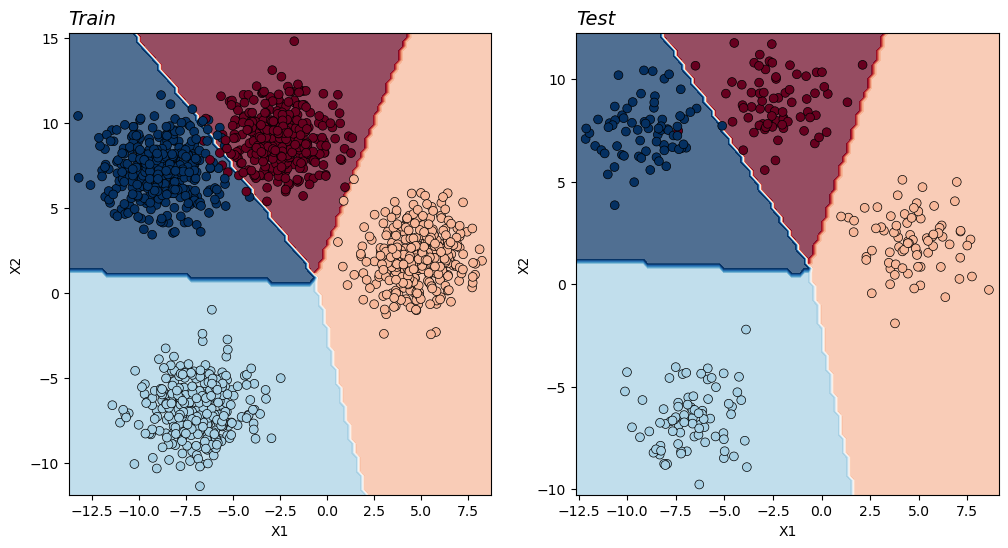

In [14]:
# We first load the hyperparameters from the saved model
with open(f'temp/models/{config.name}/hyperparameters.pkl', 'rb') as f:
    hyperparameters = pickle.load(f)

# Instantiate the model for plotting decision boundaries
model = MultiClassNetworkV1(
    n_features=hyperparameters['n_features'],
    hidden_size=hyperparameters['hidden_size'],
    n_classes=hyperparameters['n_classes'],
    device=config.device
)

# Load the weights from the saved model
state_dict = torch.load(f'temp/models/{config.name}/model.pth')

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Plot the decision boundary for the training and test datasets
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)

plot_decision_boundary(model, train_data[:, :-1], train_data[:, -1], ax=ax[0])
ax[0].set_title("Train", loc='left', fontdict={'size': 14, 'style': 'italic'})
plot_decision_boundary(model, eval_data[:, :-1], eval_data[:, -1], ax=ax[1])
ax[1].set_title("Test", loc='left', fontdict={'size': 14, 'style': 'italic'})